# Leakage detection for loop randomization

This notebook focuses on leakage detection methods.
Again, the scope is limited to first order leakage.

We will see that the methods introduced in [Key recovery](./3_key_recovery_loop.ipynb) can also be used to "detect leakage" without performing a real attack to recover the secret key.

When thinking about side-channel resistant implementations it is often not sufficient to achieve a resistance against key recovery in the classical DPA/CPA scenario. For instance template attacks are powerful weapons to break implementations. But, all techniques require that a secret "leaks" by a certain extend. Again, talking about template attacks, the first step there is to detect points-of-interest. Without them it is not possible to create good templates.

We know our implementation and have full control over the processed data. So, there is no need to assume an unknown fixed key and attack with varying input. We can _directly_ "attack" the key. Therefore we proceed as following:

1. Record traces with random key and random input.
2. Use the techniques from [Key recovery](./3_key_recovery_loop.ipynb) to see how "leaky" the key behaves.

In [2]:
%load_ext autoreload
%autoreload 2

import random

import lascar
import matplotlib.pyplot as plt
import numpy as np

import datasets
import leakage_detection_loop

lascar.logger.setLevel(lascar.logging.CRITICAL)
plt.rcParams['figure.figsize'] = [15.0, 4.0]
plt.rcParams['figure.dpi'] = 140


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example: CWXMEGA loop

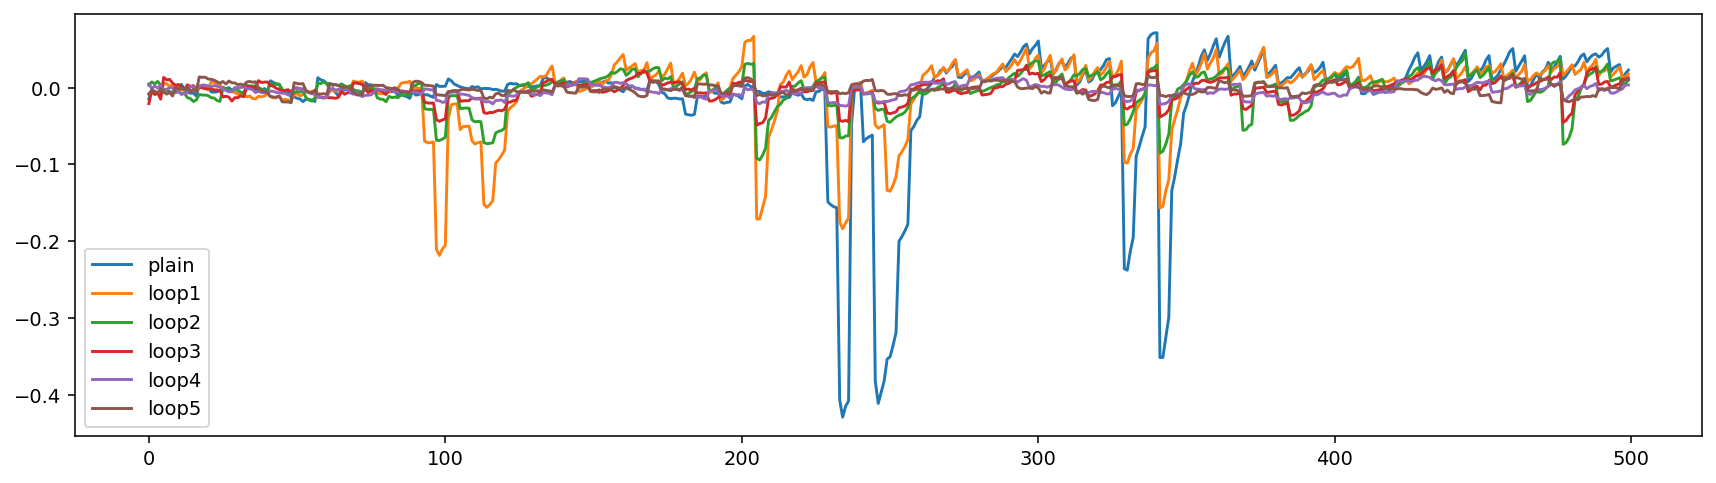

In [10]:
for name in ("plain", "loop1", "loop2", "loop3", "loop4", "loop5"):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwxmega_{name}_randomkey_randominput"),
    )
    plt.plot(cpa, label=name)

plt.legend()
plt.show()

## A Metric for Leakage

### Requirements

The plots above give a clear view: 
Leakage is higher whenever a peak is better to see and the noise floor is lower.
But it is not obvious (at least for the author) how to put this into a good formula.

Let us put the requirements for a leakage metric $m(\mathcal T)$ for a set of traces $\mathcal T$:

- r1: The leakage metric $m(\mathcal T)$ shall be monotonously increasing with the number of traces processed. <br/>
  Formally: Given two subsets $\mathcal I, J \subseteq \mathcal T$ with $|I| \leq |J|$: $m(\mathcal I) \leq m(\mathcal J)$. 
- r2: Assume a fixed trace source and a fixed leakage model and an implementation with different security levels. 
  If the key of security level $A$ can be revealed after $|\mathcal T|$ traces applying a key recovery technique and the key of security level $B$ after $|\mathcal S|$ traces then their leakage metric shall be equal: $m_A(\mathcal T) = m_B(\mathcal S)$.

### Visual inspection

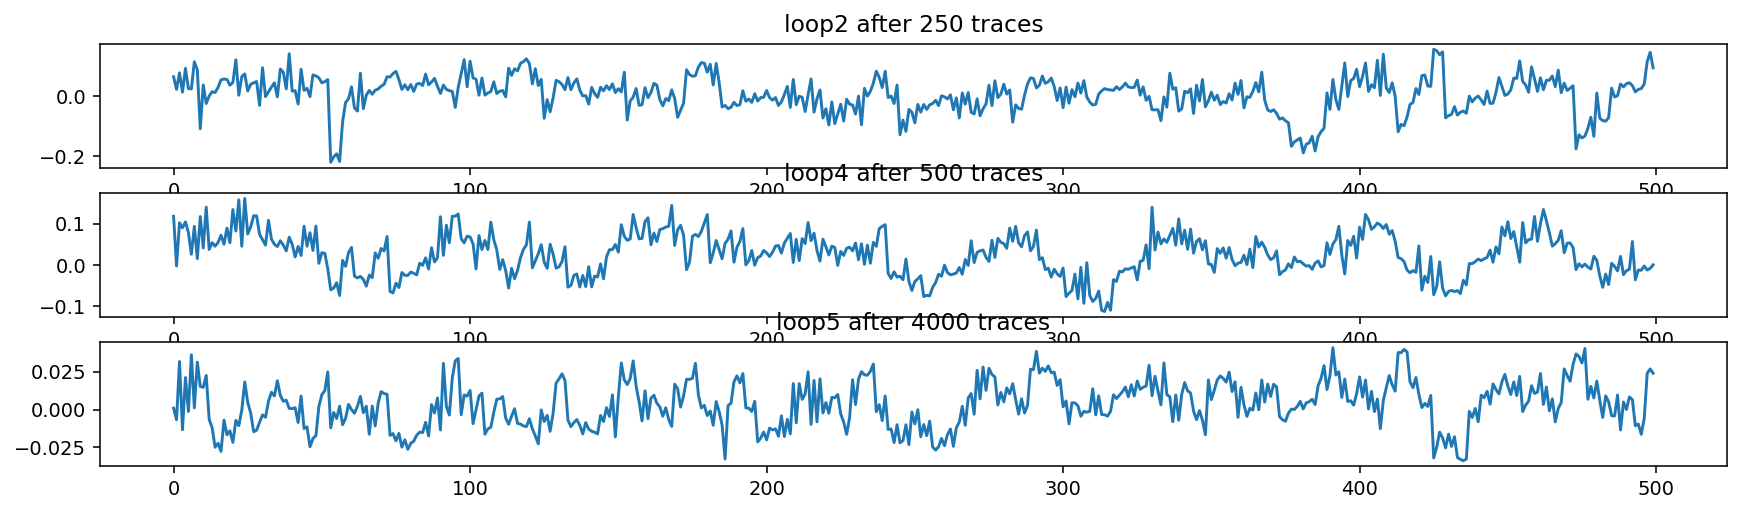

In [32]:
_, axes = plt.subplots(3, 1)

for i, (name, amount) in enumerate((
    ("loop2", 250), 
    ("loop4", 500), 
    ("loop5", 4_000), 
)):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwarm_{name}_randomkey_randominput")[:amount],
    )
    axes[i].plot(cpa)
    axes[i].set_title(f"{name} after {amount} traces")

plt.show()


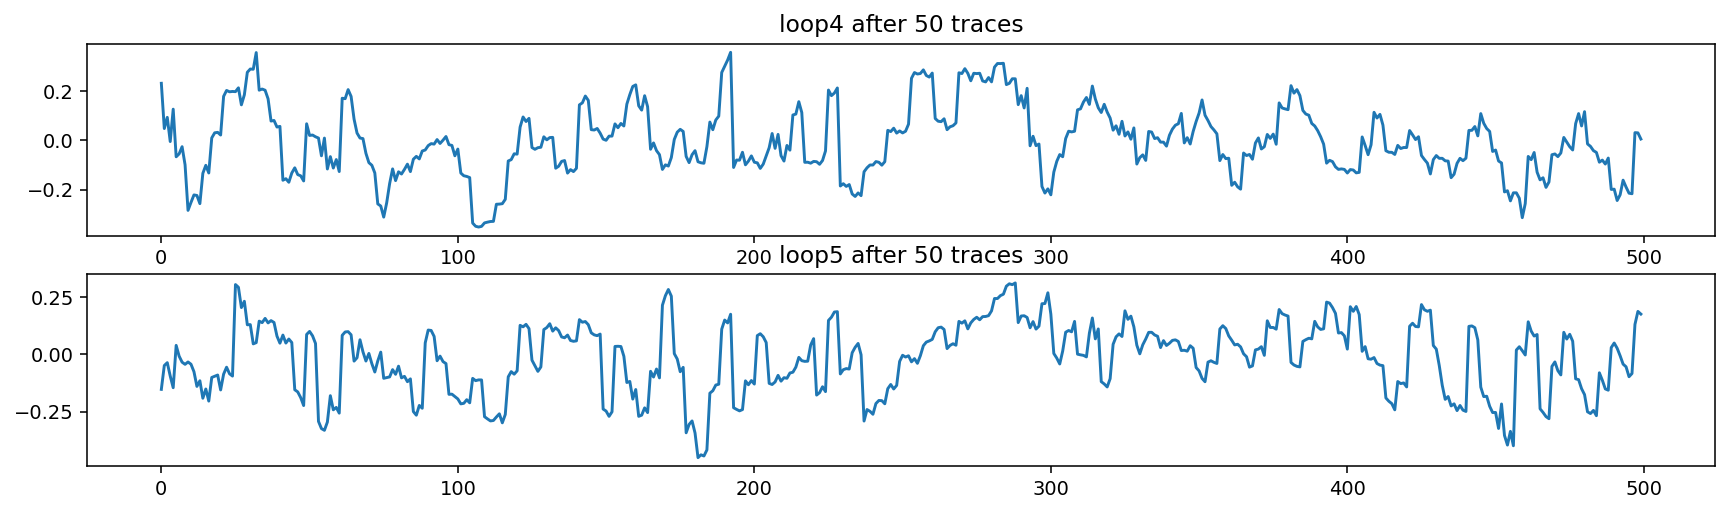

In [33]:
_, axes = plt.subplots(2, 1)

for i, (name, amount) in enumerate((
    ("loop4", 50), 
    ("loop5", 50), 
)):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwxmega_{name}_randomkey_randominput")[:amount],
    )
    axes[i].plot(cpa)
    axes[i].set_title(f"{name} after {amount} traces")

plt.show()



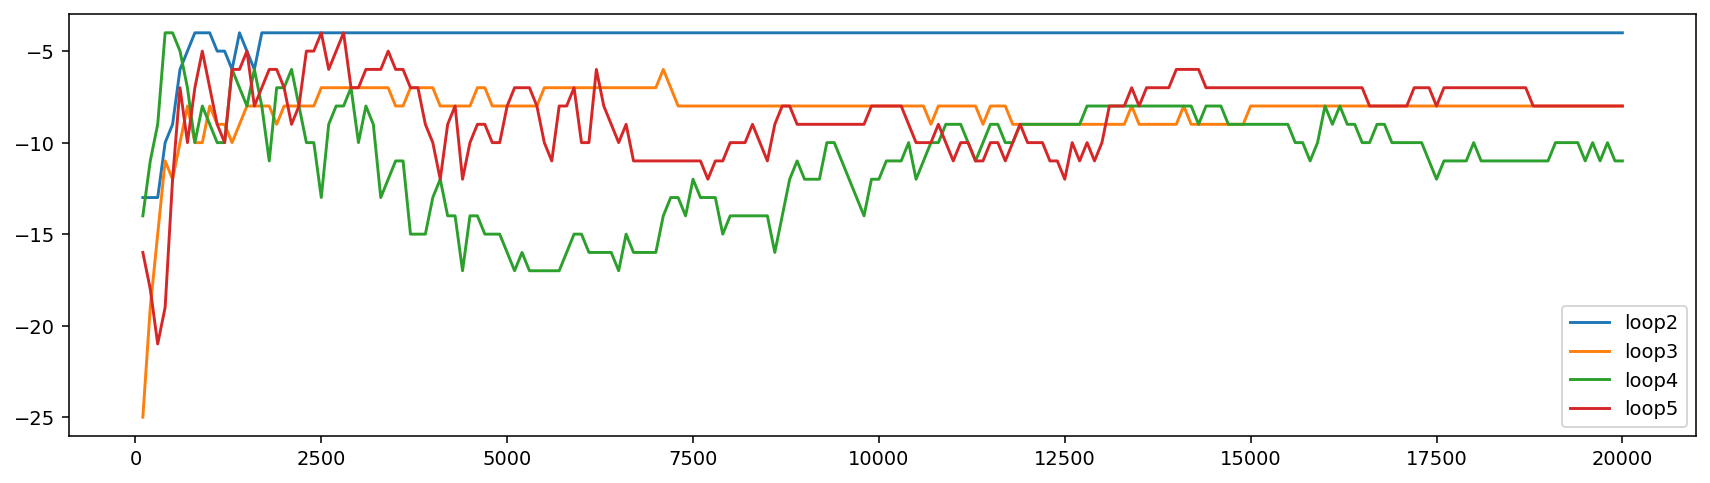

In [100]:
for i, name in enumerate(("loop2", "loop3", "loop4", "loop5")):
    metric = leakage_detection_loop.cpa_leakage_metric(
        dataset=datasets.dataset(f"cwarm_{name}_randomkey_randominput"),
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["input"][1] ^ value["key"][1]]),
    )
    plt.plot(*zip(*metric), label=name)

plt.legend()
plt.show()

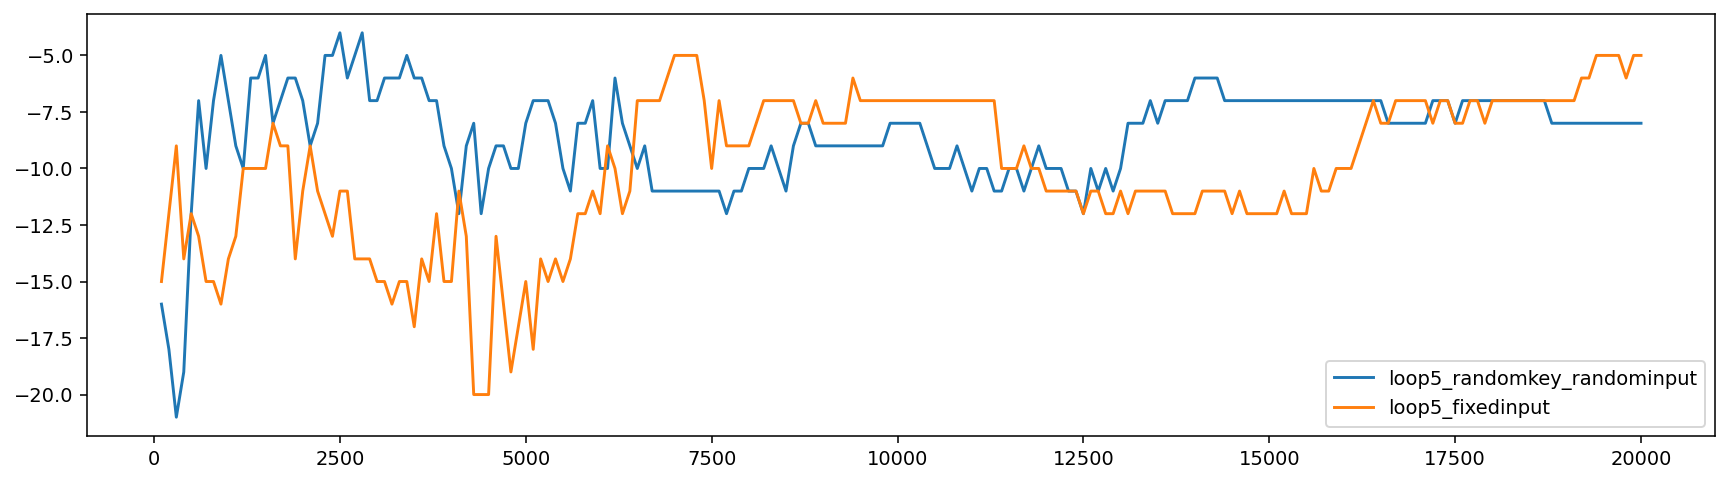

In [99]:
for i, name in enumerate(("loop5_randomkey_randominput", "loop5_fixedinput")):
    metric = leakage_detection_loop.cpa_leakage_metric(
        dataset=datasets.dataset(f"cwarm_{name}"),
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["input"][1] ^ value["key"][1]]),
    )
    plt.plot(*zip(*metric), label=name)

plt.legend()
plt.show()


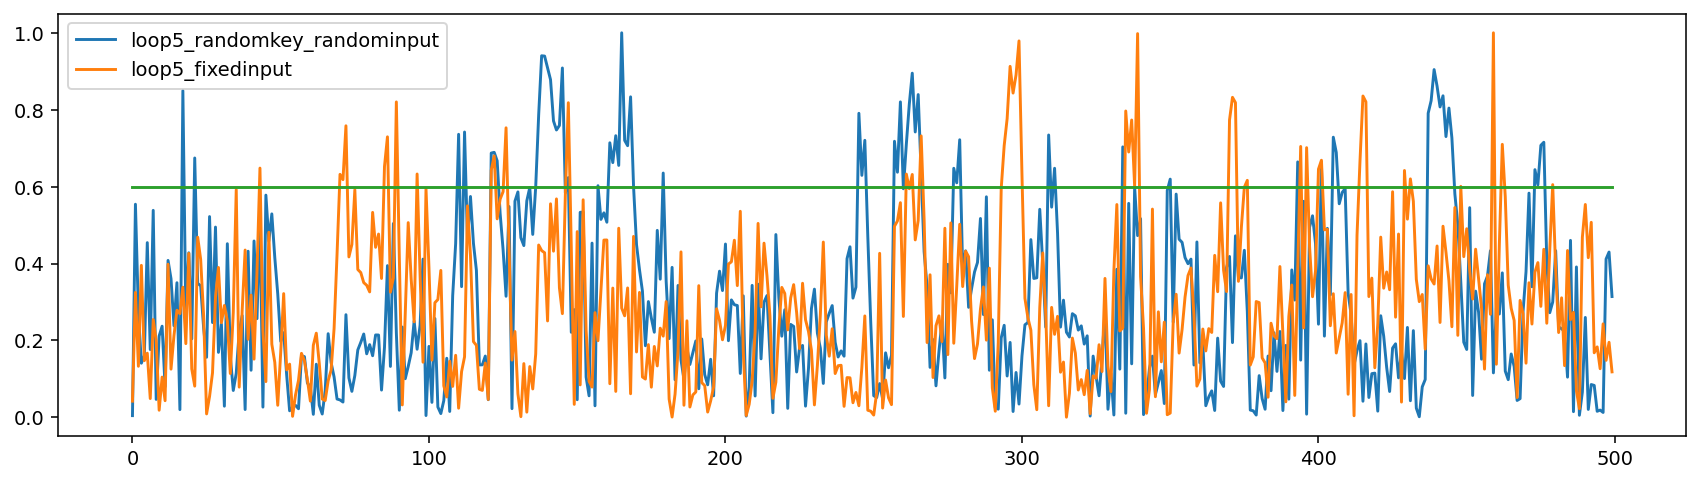

In [66]:
for i, (name, amount) in enumerate((
    ("loop5_randomkey_randominput", 100), 
    ("loop5_fixedinput", 100), 
)):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwarm_{name}")[:amount],
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["input"][1] ^ value["key"][1]]),
    )
    plt.plot(np.abs(cpa) / np.max(np.abs(cpa)), label=name)

plt.plot(500 * [0.6])
plt.legend()
plt.show()




12
12
8


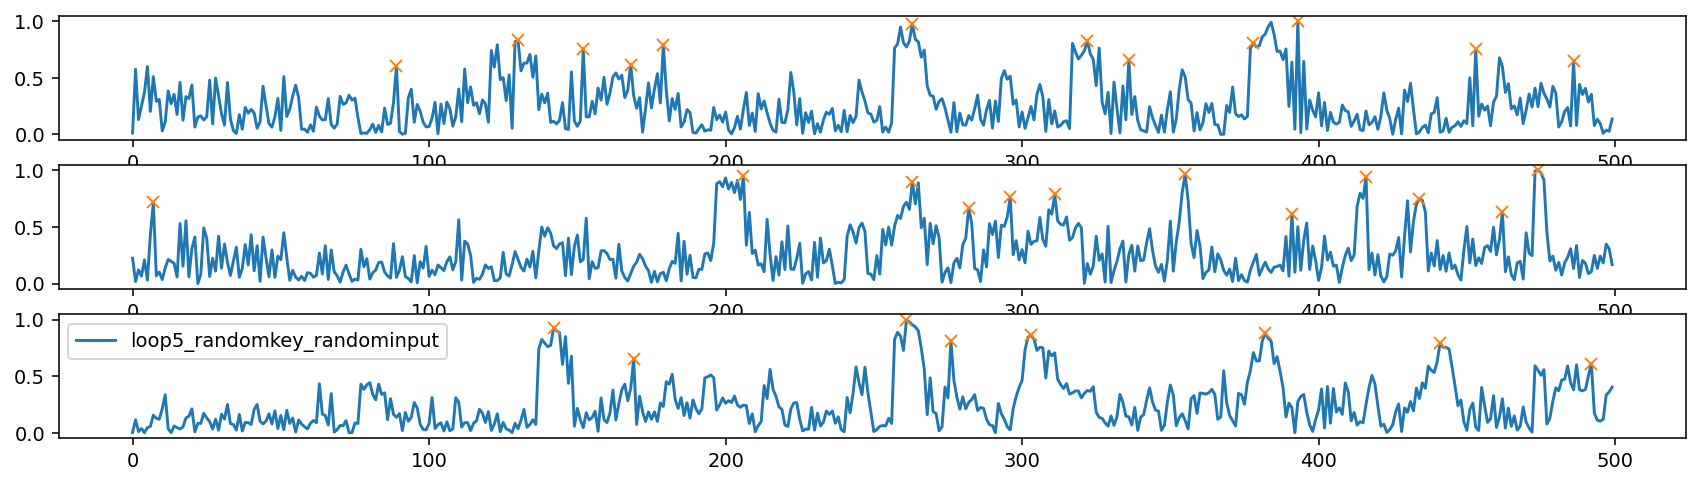

In [98]:
import scipy.signal

_, axes = plt.subplots(3, 1)

for i, (name, amount) in enumerate((
    ("loop5_randomkey_randominput", 50), 
    ("loop5_randomkey_randominput", 500), 
    ("loop5_randomkey_randominput", 5000), 
    # ("loop5_fixedinput", 5000), 
)):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwarm_{name}")[:amount],
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["input"][1] ^ value["key"][1]]),
    )
    cpa = np.abs(cpa) / np.max(np.abs(cpa))
    axes[i].plot(cpa, label=name)
    peaks, _ = scipy.signal.find_peaks(cpa, distance=10, height=0.6)
    print(len(peaks))
    axes[i].plot(peaks, cpa[peaks], "x")

plt.legend()
plt.show()

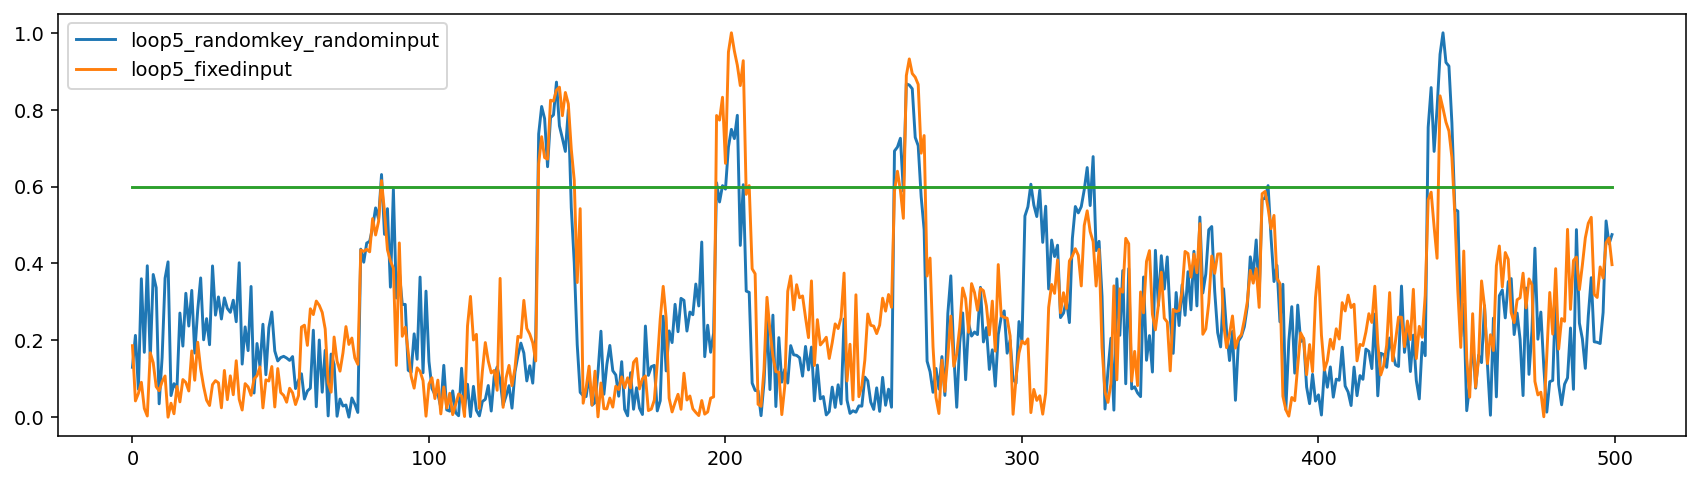

In [68]:
for i, (name, amount) in enumerate((
    ("loop5_randomkey_randominput", 20000), 
    ("loop5_fixedinput", 20000), 
)):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwarm_{name}")[:amount],
        selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["input"][1] ^ value["key"][1]]),
    )
    plt.plot(np.abs(cpa) / np.max(np.abs(cpa)), label=name)

plt.plot(500 * [0.6])
plt.legend()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


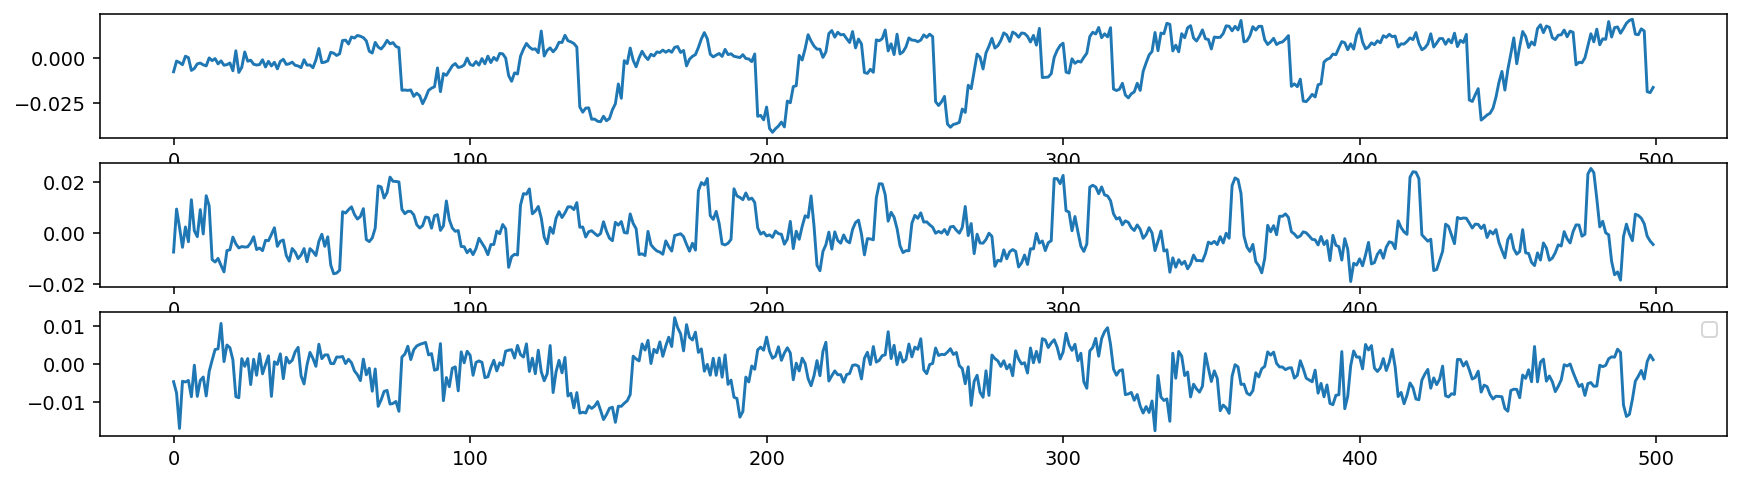

In [117]:
import scipy.signal

_, axes = plt.subplots(3, 1)

for i, (name, amount, fkt) in enumerate((
    ("loop5_fixedinput", 20000, lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["input"][1] ^ value["key"][1]])), 
    ("loop5_fixedinput", 20000, lambda value, guess: value["key"][1]), 
    ("loop5_fixedinput", 20000, lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value["key"][1]])), 
)):
    cpa = leakage_detection_loop.cpa_full(
        dataset=datasets.dataset(f"cwarm_{name}")[:amount],
        selection_function=fkt,
    )
    # cpa = np.abs(cpa) / np.max(np.abs(cpa))

    axes[i].plot(cpa)
    # axes[i].set_ylim([-0.05, 0.05])

plt.legend()
plt.show()


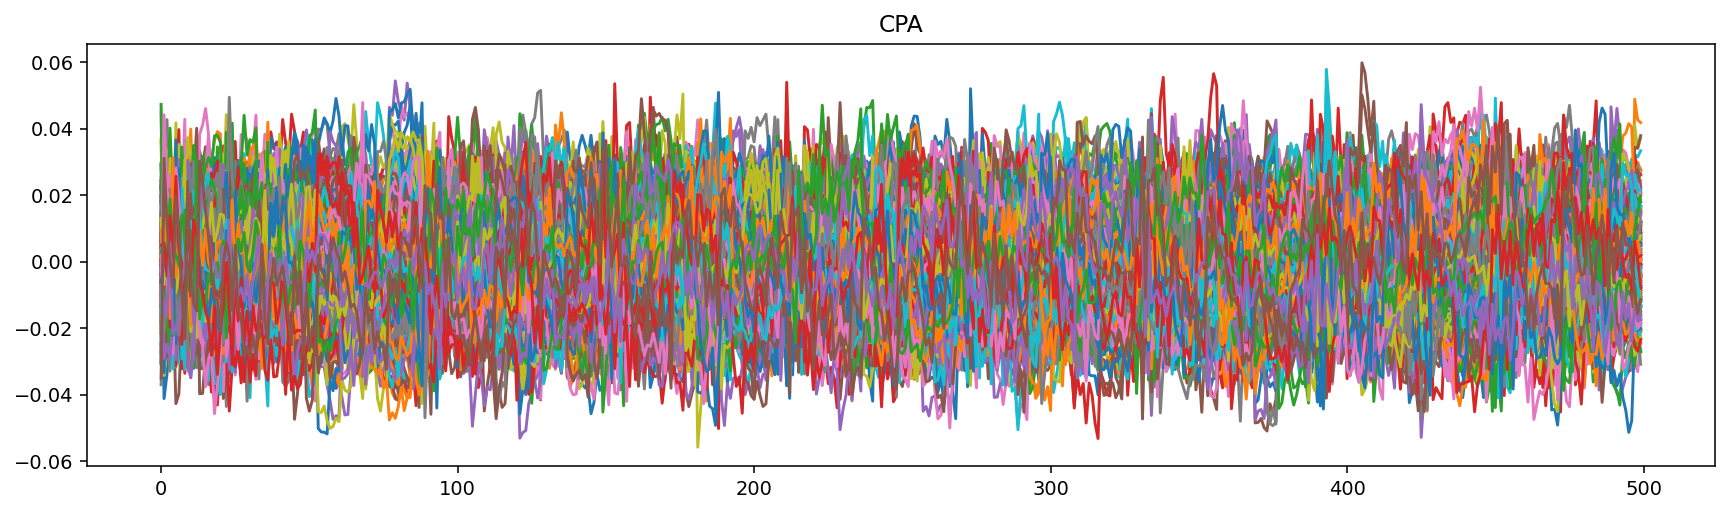

[0.05978169 0.05782263 0.05650885 0.05577788 0.05539677 0.05434151
 0.05393138 0.05349969 0.05317654 0.05307191]
[  5  99 203  18  63  44 123  23  53  84]


In [151]:
data = datasets.dataset("cwarm_loop5_fixedinput")[:5000]

class MyOut(lascar.OutputMethod):
    def _update(self, engine, result):
        resabs = np.abs(result)
        resabs = np.max(resabs, axis=1)
        print(np.sort(resabs)[::-1][:10])
        print(np.argsort(resabs)[::-1][:10])

trace = lascar.TraceBatchContainer(data["trace"], data["key"])
engine = lascar.CpaEngine(
    name="CPA",
    selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[1] ^ guess]),
    guess_range=range(256),
)
session = lascar.Session(
    trace,
    engine=engine,
    output_method=[lascar.MatPlotLibOutputMethod(engine), MyOut(engine)],
    progressbar=False,
)
session.run(batch_size=100_000)


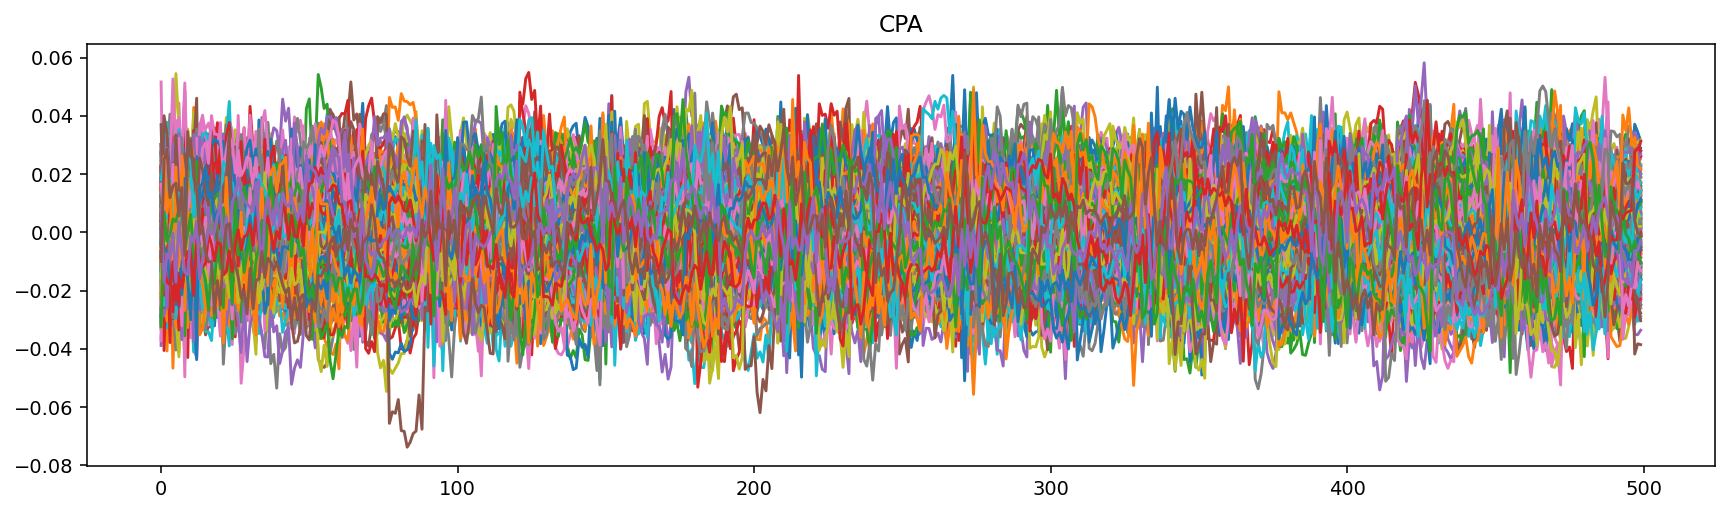

[0.07373958 0.05820458 0.05561074 0.05488959 0.05462087 0.05449358
 0.05418643 0.05408377 0.05388428 0.05385986]
[205 124 161  53 128  38 192  84 150 243]


In [150]:
data = datasets.dataset("cwarm_loop5_fixedkey")[:5000]

class MyOut(lascar.OutputMethod):
    def _update(self, engine, result):
        resabs = np.abs(result)
        resabs = np.max(resabs, axis=1)
        print(np.sort(resabs)[::-1][:10])
        print(np.argsort(resabs)[::-1][:10])

trace = lascar.TraceBatchContainer(data["trace"], data["input"])
engine = lascar.CpaEngine(
    name="CPA",
    selection_function=lambda value, guess: lascar.hamming(lascar.tools.aes.sbox[value[1] ^ guess]),
    guess_range=range(256),
)
session = lascar.Session(
    trace,
    engine=engine,
    output_method=[lascar.MatPlotLibOutputMethod(engine), MyOut(engine)],
    progressbar=False,
)
session.run(batch_size=100_000)
